# Effectiveness

In [ ]:
# -- git pull origin --rebase 
import pandas as pd 
import numpy as np
from dealib import dea
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = pd.read_excel('Data.xlsx', sheet_name = 'Fact_Academy')
data = data[data.Year.isin([2014, 2021])].reset_index(drop = True)
data_original = data.copy()
print(data.shape)
data.head(3)

(32, 14)


,Institution_YearCode,Year,Students,StudentsB.S,StudentsPhd,StudentsM.S,First_Year_Students,StudentsB.S.c_Engineering,StudentsM.S.c_Engineering,StudentsP.H.D_Engineering,Number_of_Degree_Recipients,Number_of_Bachelor's_Degree_Recipients,Number_of_Master's_Degree_Recipients,Number_of_Doctorate_Degree_Recipients
0,12021,2021,21817,13212,2329,6119.0,4356,357,0,12,5458,2801,2161,383
1,12014,2014,20624,11574,2299,6598.0,3847,282,0,7,5596,2945,2248,337
2,22021,2021,18428,12580,1668,4089.0,4206,5127,797,429,5194,3103,1744,256


In [8]:
def data_expense(column_name, expanse_code):
    ''' 
    Return all differents expenses data (or income if expanse_code = 5). 
    '''
    expenses = pd.read_excel('Data.xlsx', sheet_name = 'Expanses_Orederd1')
    expenses = expenses[(expenses.Expanse_Code == expanse_code) & (expenses.Year.isin([2014, 2021]))].drop('Expanse_Code', axis = 1)
    expenses = expenses.rename(columns = {'Amount': column_name}).reset_index(drop = True)
    return expenses

# Incomes
income_data = data_expense(column_name = 'Incomes', expanse_code = 5)
income_data.head(3)

,Institution_YearCode,Year,Incomes
0,12014,2014,2874720
1,12021,2021,2596849
2,22014,2014,1622315


In [16]:
#### Institute Data
# Institution Type
dim_institute = pd.read_excel('Data.xlsx', sheet_name = 'Dim_Institutions_YearCode')
# Institution Names 
institute_name = pd.read_excel('Data.xlsx', sheet_name = 'Dim_Institutions')
institute_name = institute_name.drop(['InstitutionOpenAlex_ID'], axis = 1)
institute_data = pd.merge(dim_institute, institute_name, on = ['Institution_Code'], how = 'inner')


final_data = data[['Institution_YearCode', 'Year', 'Students']]
final_data = pd.merge(final_data, income_data, on = ['Institution_YearCode', 'Year'], how = 'inner')
final_data = pd.merge(final_data, institute_data, on = ['Institution_YearCode'], how = 'inner').drop('Institution_Code', axis = 1)
final_data.head()

,Institution_YearCode,Year,Students,Incomes,Institution_Name,Institution_TypeID
0,12021,2021,21817,2596849,Hebrew University,1
1,12014,2014,20624,2874720,Hebrew University,1
2,22021,2021,18428,1771120,Ben-Gurion,1
3,22014,2014,18569,1622315,Ben-Gurion,1
4,32021,2021,19819,1398689,Bar-Ilan,1


In [38]:
def run_dea_inter_years(data, input_year, output_year, input_vars, output_vars, Institution_TypeID=1, lambdas=False):
    # Filtrer les données selon l'année et le type d'institution
    dea_inputs = data[(data.Year == input_year) & (data.Institution_TypeID == Institution_TypeID)]
    dea_outputs = data[(data.Year == output_year) & (data.Institution_TypeID == Institution_TypeID)]

    # Trouver les institutions communes et les trier
    common_names = sorted(list(set(dea_inputs['Institution_Name']) & set(dea_outputs['Institution_Name'])))
    dea_inputs = dea_inputs[dea_inputs['Institution_Name'].isin(common_names)].sort_values('Institution_Name')
    dea_outputs = dea_outputs[dea_outputs['Institution_Name'].isin(common_names)].sort_values('Institution_Name')

    # Extraire inputs et outputs
    inputs = dea_inputs[input_vars].to_numpy()
    outputs = dea_outputs[output_vars].to_numpy()
    dmu_names = dea_inputs['Institution_Name'].tolist()

    # Appliquer DEA
    dea_model = dea(inputs, outputs, rts="crs", orientation="input")
    efficiency = dea_model.eff

    # Créer le DataFrame des résultats
    df_eff = pd.DataFrame({"Institution_Name": dmu_names, "Effectiveness": efficiency})
    df_eff = df_eff.sort_values("Effectiveness")

    # Affichage du graphique à barres horizontal
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x="Effectiveness", y="Institution_Name", data=df_eff, palette="Blues_d")
    plt.title(f"DEA Effectiveness Scores ({input_year} Inputs → {output_year} Outputs)", fontsize=14, fontweight='bold')
    plt.xlabel("Effectiveness Score")

    # Ajouter les scores sur les barres
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

    plt.tight_layout()
    plt.show()

    # Si demandé, afficher la heatmap des lambdas
    if lambdas:
        lambda_matrix = dea_model.lambdas
        plt.figure(figsize=(18, 6))
        sns.heatmap(lambda_matrix, annot=True, cbar=False, cmap='Blues',
                    xticklabels=dmu_names, yticklabels=dmu_names)
        plt.title("Lambda Heatmap (2021 DMUs expressed as combinations of 2014 DMUs)", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    return df_eff


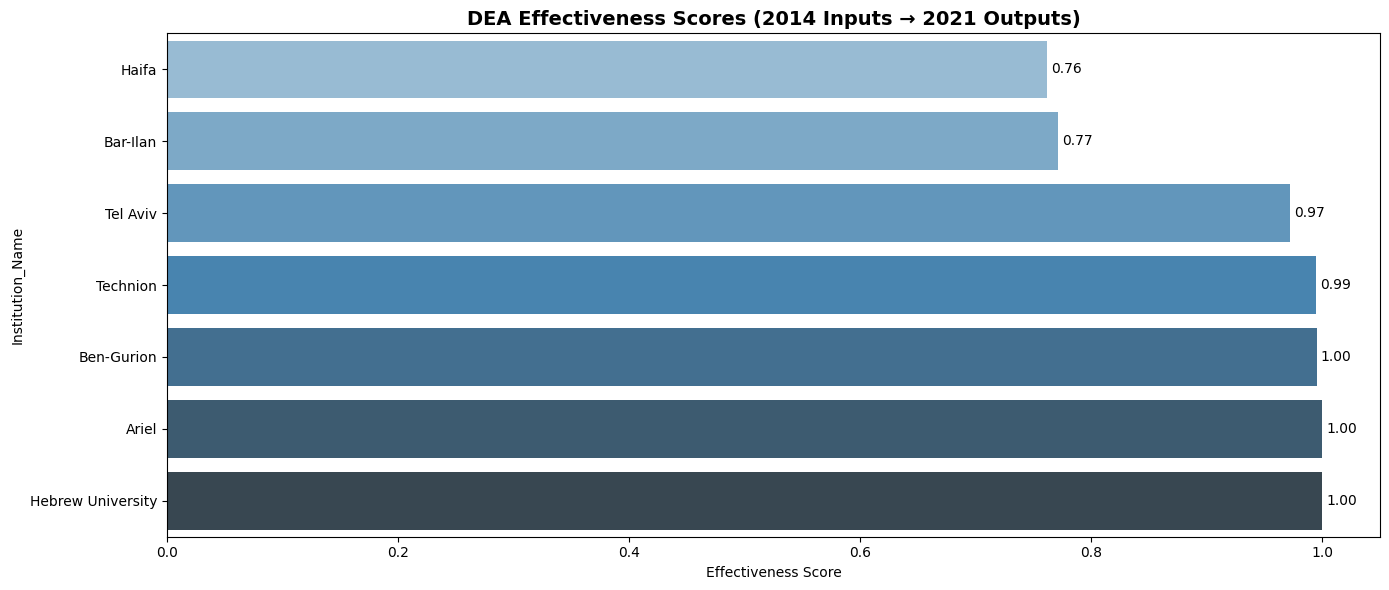

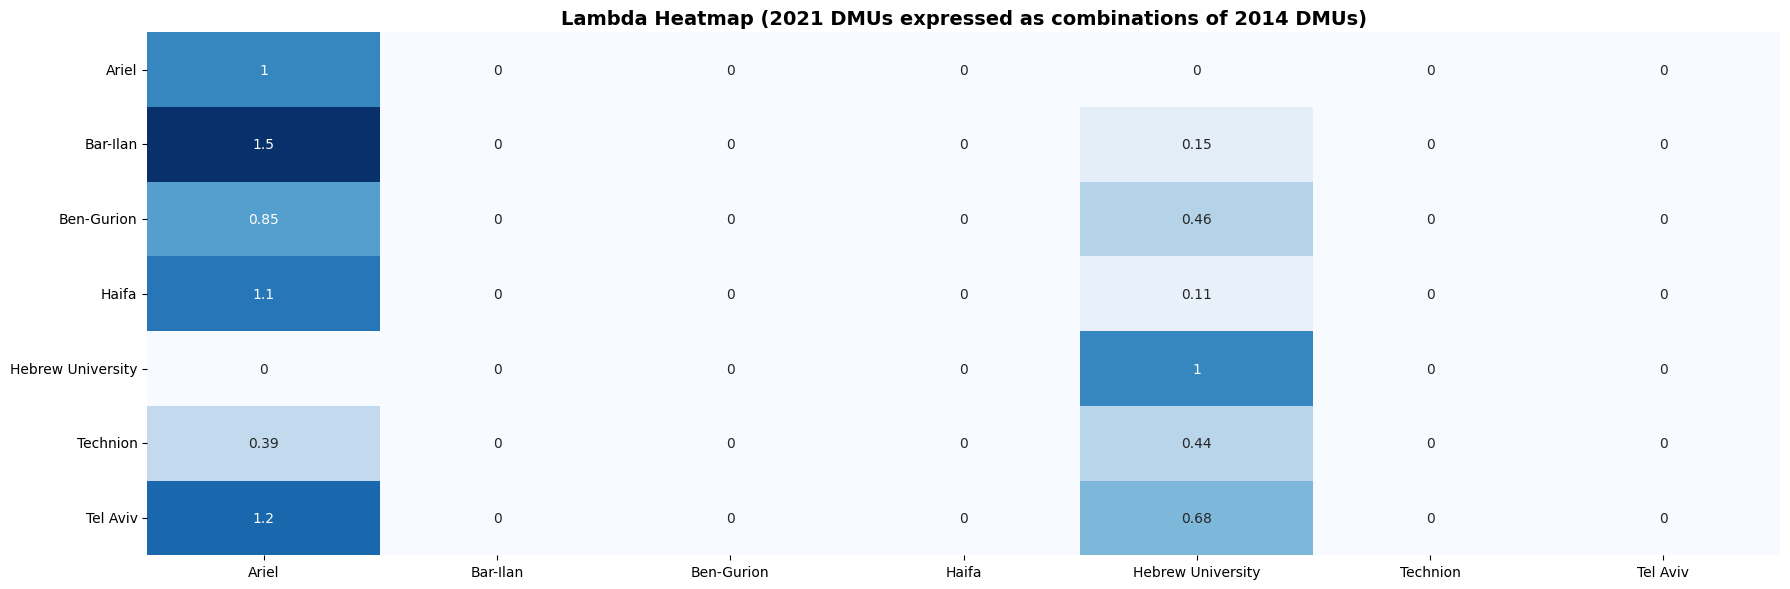

,Institution_Name,Effectiveness
3,Haifa,0.761430
1,Bar-Ilan,0.770956
6,Tel Aviv,0.971961
5,Technion,0.994207
2,Ben-Gurion,0.995256
0,Ariel,1.000000
4,Hebrew University,1.000000


In [39]:
run_dea_inter_years(
    data=final_data,
    input_year=2014,
    output_year=2021,
    input_vars=['Students', 'Incomes'],
    output_vars=['Students', 'Incomes'],
    Institution_TypeID=1,
    lambdas=True
)


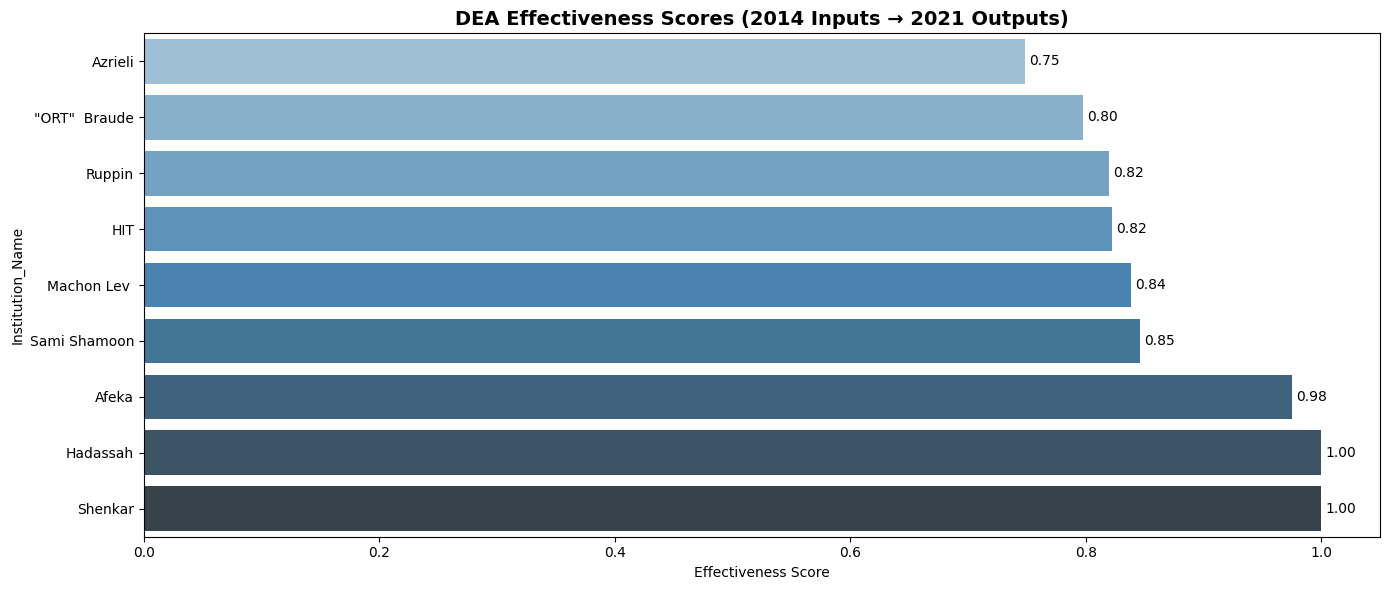

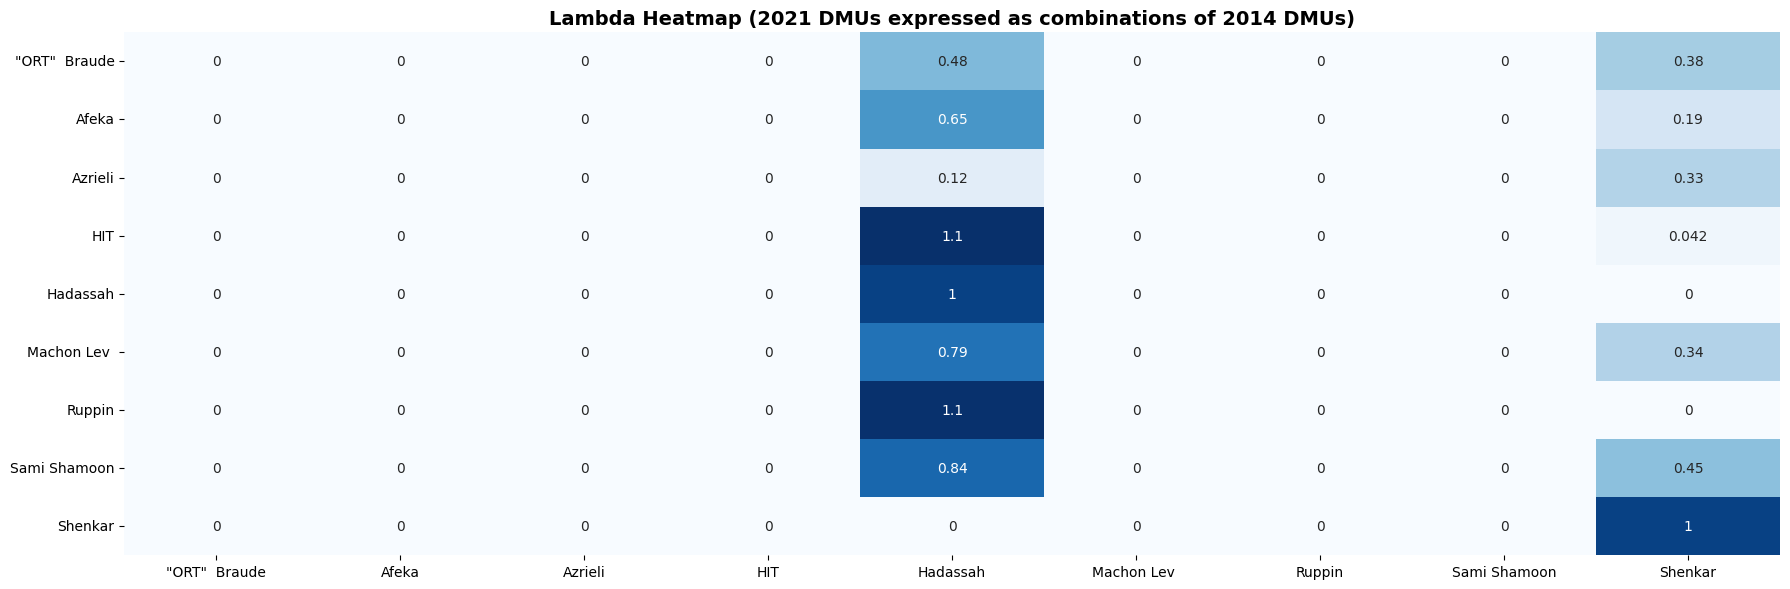

,Institution_Name,Effectiveness
2,Azrieli,0.748227
0,"""ORT"" Braude",0.797643
6,Ruppin,0.820159
3,HIT,0.822230
5,Machon Lev,0.838203
7,Sami Shamoon,0.846119
1,Afeka,0.975142
4,Hadassah,1.000000
8,Shenkar,1.000000


In [40]:
run_dea_inter_years(
    data=final_data,
    input_year=2014,
    output_year=2021,
    input_vars=['Students', 'Incomes'],
    output_vars=['Students', 'Incomes'],
    Institution_TypeID=2,
    lambdas=True
)